# Example for cmesh2d and pygmsh

In [1]:
import pygmsh
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from ttcrpy import cmesh2d

Define some function for the slowness

In [2]:
def f0(x, y):
    return 1./(0.6 + 0.2*y + 0.005*x**2)
def f1(x, y):
    return 1./(1. + 0.2*y + 0.005*x**2)
def f2(x, y):
    return 1./(1.3 + 0.2*y - 0.003*x**2)

Create a mesh with pygmsh

In [3]:
geom = pygmsh.built_in.Geometry()

lcar = 0.5

pts = []
pts.append(geom.add_point((0.0, 0.0, 0.0), lcar))    # 0
pts.append(geom.add_point((1.0, 0.0, 0.0), lcar))    # 1
pts.append(geom.add_point((5.0, 0.0, -2.0), lcar))   # 2
pts.append(geom.add_point((10.0, 0.0, 2.0), lcar))   # 3
pts.append(geom.add_point((14.0, 0.0, 0.0), lcar))   # 4
pts.append(geom.add_point((15.0, 0.0, 0.0), lcar))   # 5
pts.append(geom.add_point((15.0, 0.0, 4.0), lcar))   # 6 
pts.append(geom.add_point((10.0, 0.0, 3.0), lcar))   # 7 
pts.append(geom.add_point((5.0, 0.0, 5.0), lcar))    # 8 
pts.append(geom.add_point((0.0, 0.0, 4.0), lcar))    # 9 
pts.append(geom.add_point((15.0, 0.0, 8.0), lcar))   # 10
pts.append(geom.add_point((0.0, 0.0, 8.0), lcar))    # 11

pts.append(geom.add_point((3.0, 0.0, 5.0), lcar))    # 12
pts.append(geom.add_point((9.0, 0.0, 5.0), lcar))    # 13
pts.append(geom.add_point((9.0, 0.0, 7.0), lcar))    # 14
pts.append(geom.add_point((3.0, 0.0, 7.0), lcar))    # 15


lines = []
lines.append(geom.add_bspline(pts[:6]))           # 0
lines.append(geom.add_line(pts[5], pts[6]))       # 1
lines.append(geom.add_bspline(pts[6:10]))         # 2
lines.append(geom.add_line(pts[9], pts[0]))       # 3

lines.append(geom.add_line(pts[6], pts[10]))      # 4
lines.append(geom.add_line(pts[10], pts[11]))     # 5
lines.append(geom.add_line(pts[11], pts[9]))      # 6

lines.append(geom.add_line(pts[12], pts[13]))     # 7
lines.append(geom.add_line(pts[13], pts[14]))     # 8
lines.append(geom.add_line(pts[14], pts[15]))     # 9
lines.append(geom.add_line(pts[15], pts[12]))     # 10

ll0 = geom.add_line_loop(lines[7:])
ll1 = geom.add_line_loop(lines[:4])
ll2 = geom.add_line_loop((-lines[2], lines[4], lines[5], lines[6]))

surf0 = geom.add_plane_surface(ll0)
surf1 = geom.add_plane_surface(ll1)
surf2 = geom.add_plane_surface(ll2, (ll0,))

geom.add_physical(surf0, 'hole')
geom.add_physical(surf1, 'layer_1')
geom.add_physical(surf2, 'layer_2')

mesh = pygmsh.generate_mesh(geom)

Info    : Running 'gmsh -3 /var/folders/j6/s0152dxj3q54bsjvw2s42b0m0000gn/T/tmp0bziqr61.geo -format msh -bin -o /var/folders/j6/s0152dxj3q54bsjvw2s42b0m0000gn/T/tmp4j0myfmc.msh' [Gmsh 4.5.4, 1 node, max. 1 thread]
Info    : Started on Sat Mar 21 10:40:10 2020
Info    : Reading '/var/folders/j6/s0152dxj3q54bsjvw2s42b0m0000gn/T/tmp0bziqr61.geo'...
Info    : Done reading '/var/folders/j6/s0152dxj3q54bsjvw2s42b0m0000gn/T/tmp0bziqr61.geo'
Info    : Meshing 1D...
Info    : [  0 %] Meshing curve 1 (Nurb)
Info    : [ 10 %] Meshing curve 2 (Line)
Info    : [ 20 %] Meshing curve 3 (Nurb)
Info    : [ 30 %] Meshing curve 4 (Line)
Info    : [ 40 %] Meshing curve 5 (Line)
Info    : [ 50 %] Meshing curve 6 (Line)
Info    : [ 60 %] Meshing curve 7 (Line)
Info    : [ 70 %] Meshing curve 8 (Line)
Info    : [ 80 %] Meshing curve 9 (Line)
Info    : [ 90 %] Meshing curve 10 (Line)
Info    : [100 %] Meshing curve 11 (Line)
Info    : Done meshing 1D (0.009655 s)
Info    : Meshing 2D...
Info    : [  0 %] Mesh

```cmesh2d``` want (x,z) coordinates, extract those from the mesh

In [4]:
nodes = np.vstack((mesh.points[:,0], mesh.points[:,2])).T

triangles = mesh.cells_dict['triangle']

Compute centroid of triangles and compute slowness at these coordonates

In [5]:
phys = np.hstack(mesh.cell_data['gmsh:physical'])
slowness = np.empty((triangles.shape[0],))
for n in range(triangles.shape[0]):
    t = triangles[n]
    x = (nodes[t[0],0] + nodes[t[1],0] + nodes[t[2],0])/3.0
    z = (nodes[t[0],1] + nodes[t[1],1] + nodes[t[2],1])/3.0

    if phys[n] == 1:
        slowness[n] = f0(np.array(x), np.array(z))
    elif phys[n] == 2:
        slowness[n] = f1(np.array(x), np.array(z))
    else:
        slowness[n] = f2(np.array(x), np.array(z))

V = 1./slowness   # for plotting

Create mesh and define source & receivers

In [6]:
m1 = cmesh2d.Mesh2D(nodes, triangles, nsecondary=10, nthreads=1)

Tx = np.array([[0.15, 0.15]])
t0 = np.array([0.0])

Rx = np.array([[2.0, -0.4],
               [5.0, -0.7],
               [7.0, -0.1],
               [10.0, 1.0],
               [14.0, 0.2],
               [14.5, 2.0],
               [14.5, 3.0],
               [14.5, 4.0],
               [14.5, 5.0],
               [14.5, 6.0],
               [14.5, 7.0]])

Compute traveltimes & raypaths

In [7]:
tt, _, rays = m1.raytrace(slowness, Tx, Rx, t0, nout=3)

Show raypaths

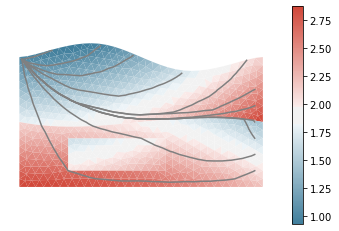

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

patches = []
for t in triangles:
    pts = np.array([[nodes[t[0],0], nodes[t[0],1]],
                    [nodes[t[1],0], nodes[t[1],1]],
                    [nodes[t[2],0], nodes[t[2],1]]])
    p = matplotlib.patches.Polygon(pts, closed=True)
    patches.append(p)
colors = V

cmap = sns.diverging_palette(230, 15, sep=20, as_cmap=True)

p = matplotlib.collections.PatchCollection(patches, cmap=cmap)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.colorbar(p, ax=ax)
for r in rays:
    plt.plot(r[:,0], r[:,1], c=[0.5, 0.5, 0.5])

ax.invert_yaxis()
plt.axis('off')
plt.show()

Check traveltime values

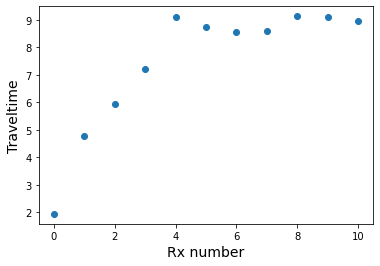

In [9]:
fig = plt.figure()
plt.plot(tt, 'o')
plt.xlabel('Rx number', fontsize=14)
plt.ylabel('Traveltime', fontsize=14)
plt.show()

Extract traveltimes at all nodes and export to VTK format for visualization in other software (e.g. Paraview).

In [12]:
tt_all = m1.get_grid_traveltimes()
tt_all.shape
#fields = {'Velocity': V, 'Traveltime': tt_all}
#m1.to_vtk(fields, 'example_cmesh2d')

(646,)

Check raytracing options

In [ ]:
help(m1.raytrace)